In [1]:
from dotenv import load_dotenv
load_dotenv()

import os

# Test
print(os.getenv("CLIMATETRACE_DB"))

climatetrace


In [39]:
# grabbing data from asset table

asset_query = '''
    select ca.name country_name
        , ae.iso3_country
        , original_inventory_sector
        , to_char(start_time, 'YYYY-MM') as year_month
        , ae.gas
        , sum(activity) activity
        , avg(emissions_factor) mean_emissions_factor
        , sum(emissions_quantity) emissions_quantity

    from asset_emissions ae
    left join country_analysis ca
        on cast(ca.iso3_country as varchar) = cast(ae.iso3_country as varchar)

    where extract(year from start_time) >= 2023
        and ae.gas = 'co2e_100yr'
        and original_inventory_sector in ('international-shipping','domestic-shipping')
        and most_granular = true

    group by ca.name
        , ae.iso3_country
        , original_inventory_sector
        , to_char(start_time, 'YYYY-MM')
        , end_time
        , ae.gas
'''

asset_df = run_sql(asset_query)

/Users/anthonyrusso/Documents/statistics-visualization-tool/utils/run_sql.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, conn)


In [40]:
asset_df

,country_name,iso3_country,original_inventory_sector,year_month,gas,activity,mean_emissions_factor,emissions_quantity
0,Afghanistan,AFG,international-shipping,2023-03,co2e_100yr,1361.317505,3.423796,4660.872955
1,Åland Islands,ALA,domestic-shipping,2023-01,co2e_100yr,7204.848858,0.705819,4304.225057
2,Åland Islands,ALA,domestic-shipping,2023-02,co2e_100yr,10260.580337,0.551878,2555.613160
3,Åland Islands,ALA,domestic-shipping,2023-03,co2e_100yr,8164.941742,0.724461,4719.612950
4,Åland Islands,ALA,domestic-shipping,2023-04,co2e_100yr,21370.479732,0.738130,16130.183859
...,...,...,...,...,...,...,...,...
11176,Yemen,YEM,international-shipping,2024-10,co2e_100yr,62981.106150,0.152232,10360.201245
11177,Yemen,YEM,international-shipping,2024-11,co2e_100yr,67711.491604,0.138828,12158.820812
11178,Yemen,YEM,international-shipping,2024-12,co2e_100yr,69290.807962,0.238348,11871.185087
11179,Yemen,YEM,international-shipping,2025-01,co2e_100yr,66499.402784,0.177861,13216.153927


In [41]:
asset_df.to_csv('data/country_monthly/month_country_subsector.csv', index=False)

In [42]:
import pandas as pd

df = pd.read_csv('data/country_monthly/month_country_subsector.csv')



In [43]:
global_df = df.groupby('year_month').agg({
    'activity': 'sum',
    'mean_emissions_factor': 'mean',
    'emissions_quantity': 'sum'
}).reset_index()

In [30]:
df.columns

Index(['country_name', 'iso3_country', 'original_inventory_sector', 'month',
       'year', 'gas', 'activity', 'mean_emissions_factor',
       'emissions_quantity', 'month_year'],
      dtype='object')

In [49]:
print(global_df.dtypes)

year_month                object
activity                 float64
mean_emissions_factor    float64
emissions_quantity       float64
dtype: object


In [50]:
global_df['year_month'] = pd.to_datetime(global_df['year_month'])

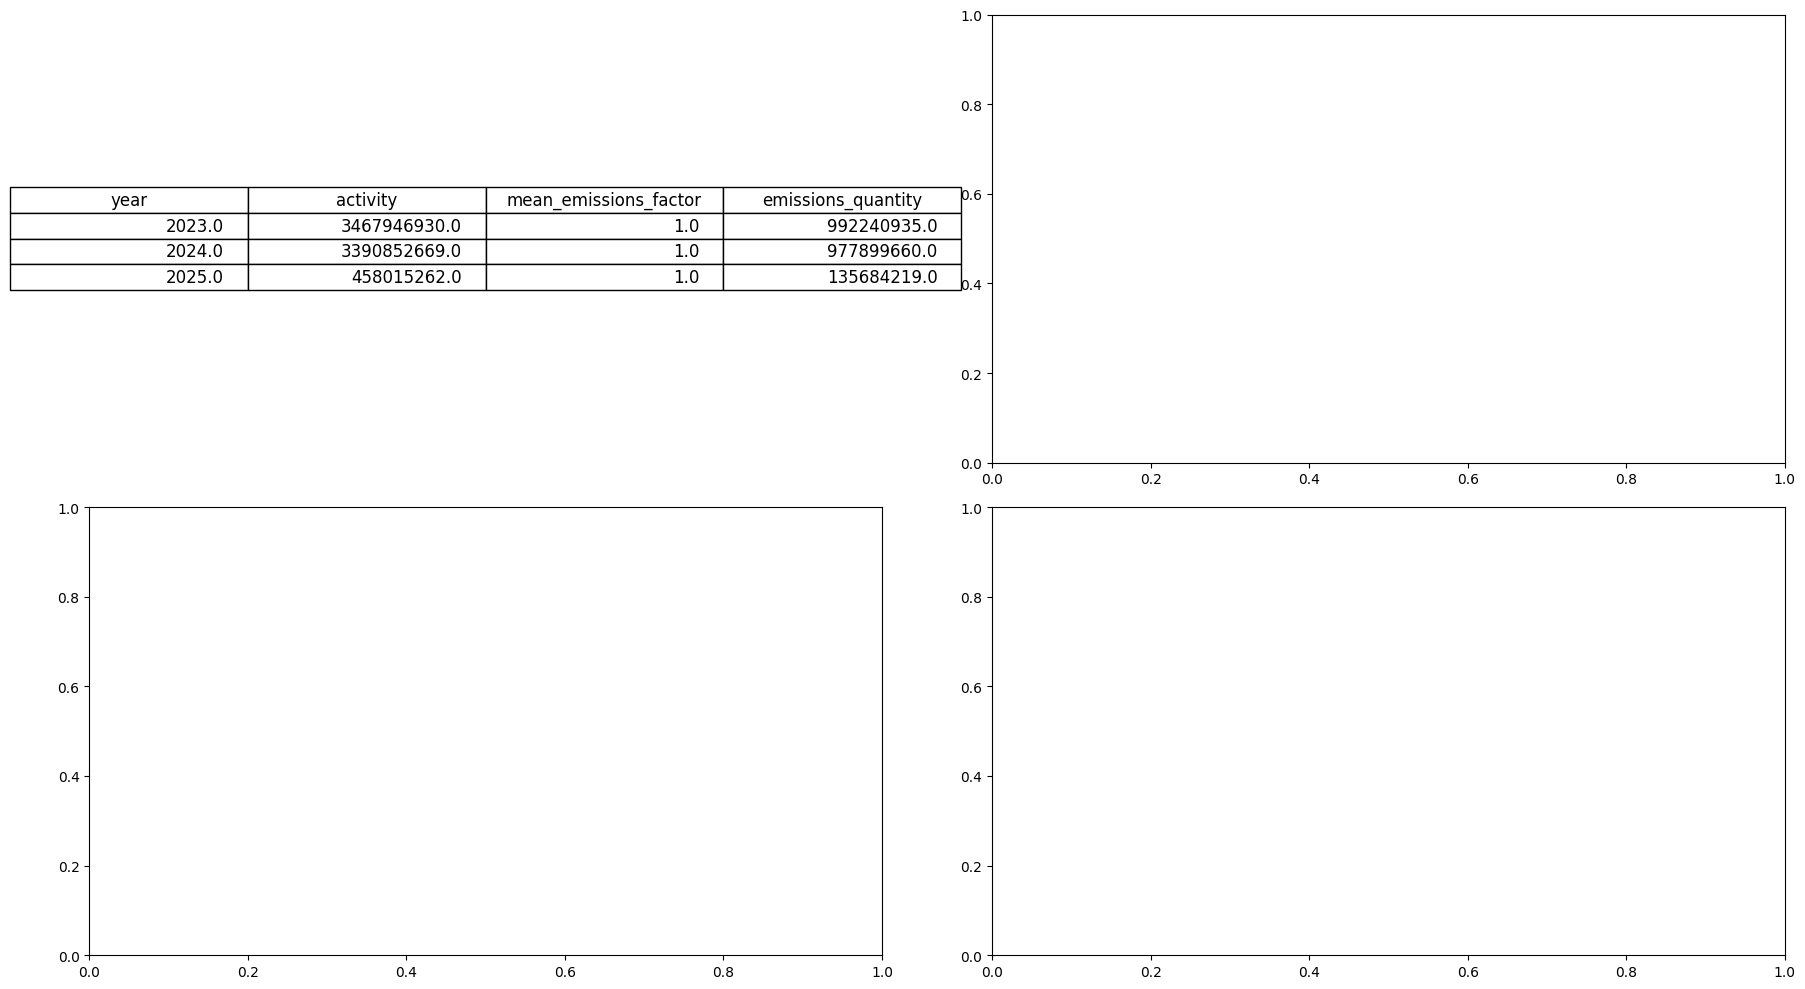

In [ ]:


monthly_global_df = df.groupby('year_month').agg({
    'activity': 'sum',
    'mean_emissions_factor': 'mean',
    'emissions_quantity': 'sum'
}).reset_index()

# convert year_month to datetime for better plotting behavior
monthly_global_df['year_month'] = pd.to_datetime(global_df['year_month'])


# create subplot with 4 different slots for a high-level global view
fig, axes = plt.subplots(2,2,figsize=(18,10))



plt.tight_layout()
plt.show()

In [54]:
df['year_month'] = pd.to_datetime(df['year_month'])
df['year'] = df['year_month'].dt.year

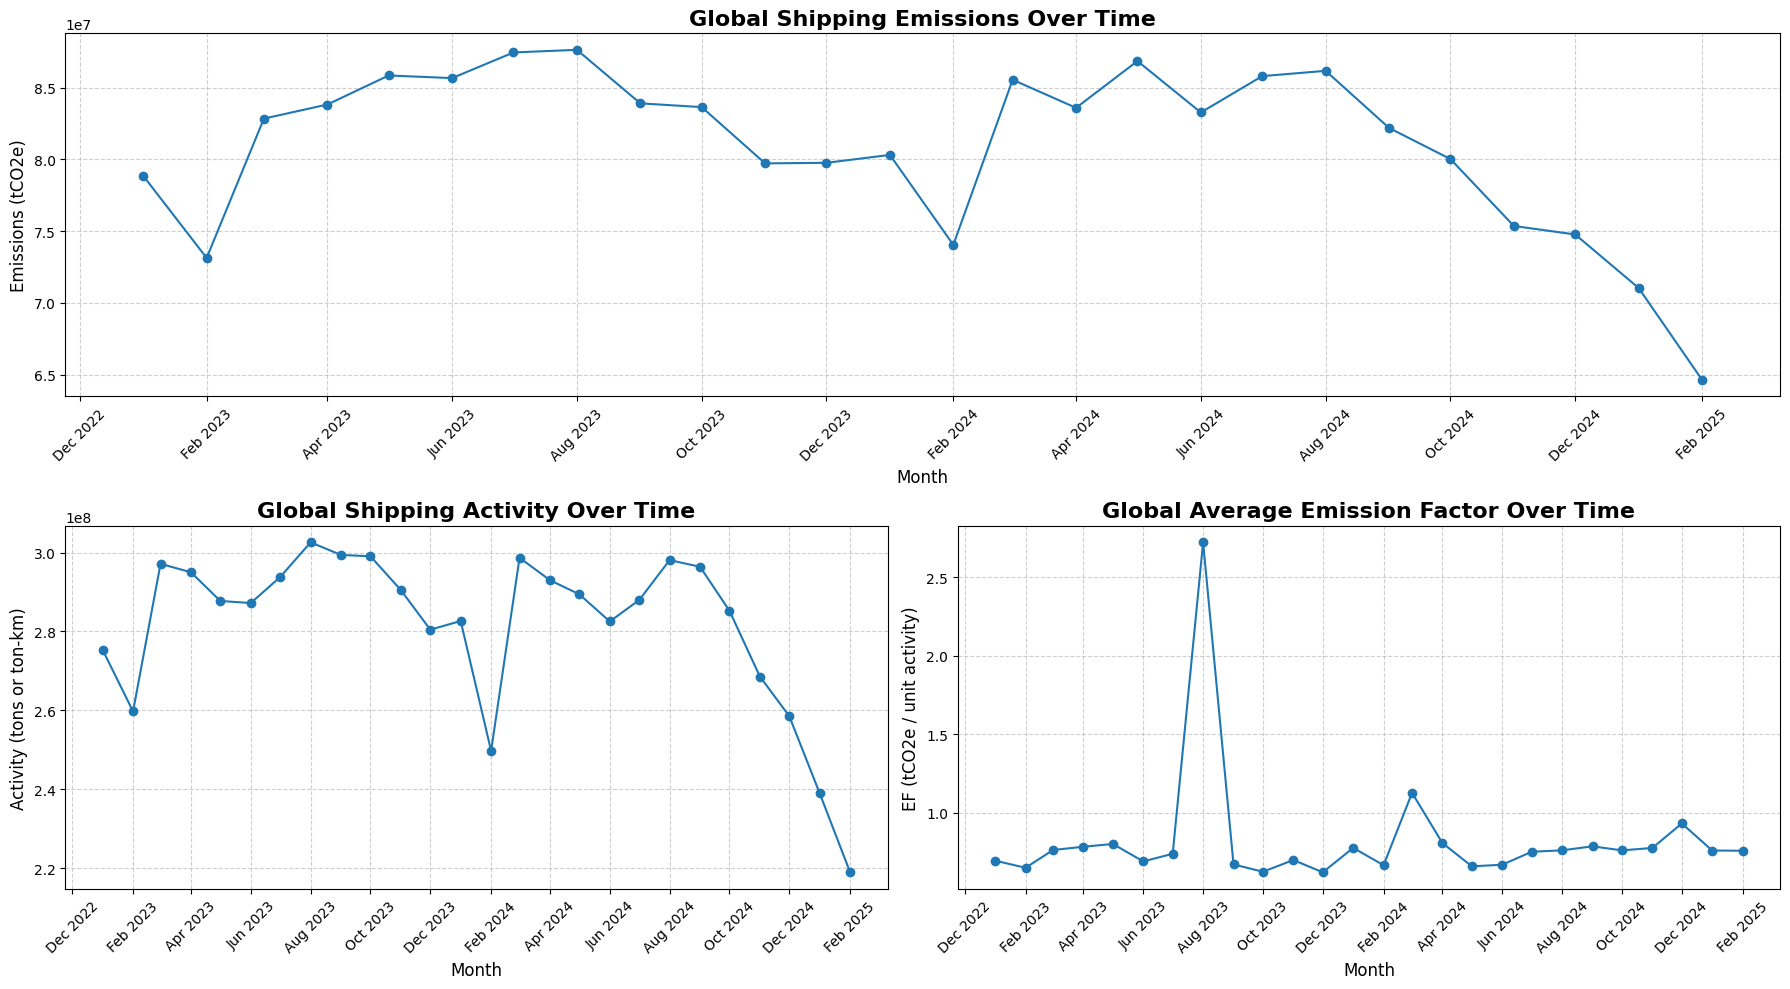

In [72]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

# Create figure
fig = plt.figure(figsize=(18, 10))

# Create GridSpec
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Create axes
ax1 = fig.add_subplot(gs[0, :])   # Top row, span BOTH columns (emissions)

ax2 = fig.add_subplot(gs[1, 0])   # Bottom left (activity)
ax3 = fig.add_subplot(gs[1, 1])   # Bottom right (emission factor)


import matplotlib.dates as mdates

# Plot Emissions
ax1.plot(global_df['year_month'], monthly_global_df['emissions_quantity'], marker='o', linestyle='-')

# Titles and labels
ax1.set_title('Global Shipping Emissions Over Time', fontsize=16, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Emissions (tCO2e)', fontsize=12)

# Grid
ax1.grid(True, linestyle='--', alpha=0.6)

# Format x-axis dates
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2 months
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax1.tick_params(axis='x', rotation=45)


# Plot Activity
ax2.plot(monthly_global_df['year_month'], monthly_global_df['activity'], marker='o', linestyle='-')

ax2.set_title('Global Shipping Activity Over Time', fontsize=16, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Activity (tons or ton-km)', fontsize=12)

ax2.grid(True, linestyle='--', alpha=0.6)

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax2.tick_params(axis='x', rotation=45)


# Plot Emission Factor
ax3.plot(monthly_global_df['year_month'], monthly_global_df['mean_emissions_factor'], marker='o', linestyle='-')

ax3.set_title('Global Average Emission Factor Over Time', fontsize=16, fontweight='bold')
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('EF (tCO2e / unit activity)', fontsize=12)

ax3.grid(True, linestyle='--', alpha=0.6)

ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()


In [ ]:
import streamlit as st
import pandas as pd

monthly_global_df = df.groupby('year_month').agg({
    'activity': 'sum',
    'mean_emissions_factor': 'mean',
    'emissions_quantity': 'sum'
}).reset_index()

# Title
st.title("Global Shipping Emissions Dashboard")

# Emissions - full width
st.subheader("Global Emissions Over Time")
st.line_chart(monthly_global_df.set_index('year_month')['emissions_quantity'])

# Activity + EF side by side
col1, col2 = st.columns(2)

with col1:
    st.subheader("Global Activity Over Time")
    st.line_chart(moonthly_global_df.set_index('year_month')['activity'])

with col2:
    st.subheader("Global Emission Factor Over Time")
    st.line_chart(monthly_global_df.set_index('year_month')['mean_emissions_factor'])


2025-04-29 10:35:48.774 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 10:35:48.793 
  command:

    streamlit run /Users/anthonyrusso/Documents/statistics-visualization-tool/.venv/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-04-29 10:35:48.793 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 10:35:48.793 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 10:35:48.793 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 10:35:49.035 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 10:35:49.036 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare m

NameError: name 'moonthly_global_df' is not defined

<Figure size 640x480 with 0 Axes>